<a href="https://colab.research.google.com/github/Mrshreesharma/Binary-Classification-on-Titanic-Dataset/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Classification Model

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc


In [ ]:
# Load dataset
df = pd.read_csv('titanic.csv')

df.dropna(inplace=True)  # drop rows with missing values for simplicity


In [ ]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Exploratory Data Analysis (EDA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [ ]:
# 1. Rename columns to avoid spaces/slashes
df.rename(columns={
    'Siblings/Spouses Aboard': 'SibSp',
    'Parents/Children Aboard': 'Parch'
}, inplace=True)

# 2. Ensure 'Sex' is string (for safety and plotting)
df['Sex'] = df['Sex'].astype(str)

# 3. Check types after rename and conversion
print(df.dtypes)


Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
dtype: object


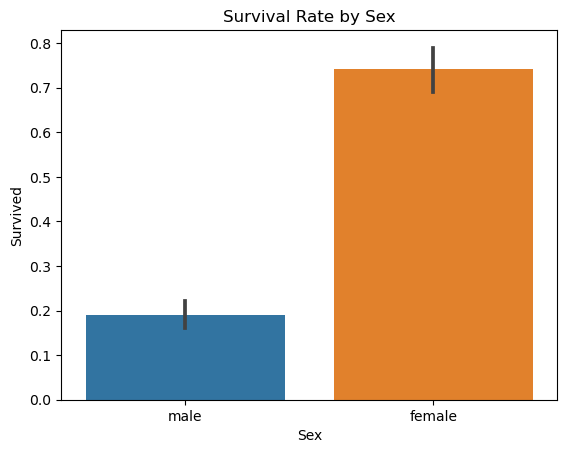

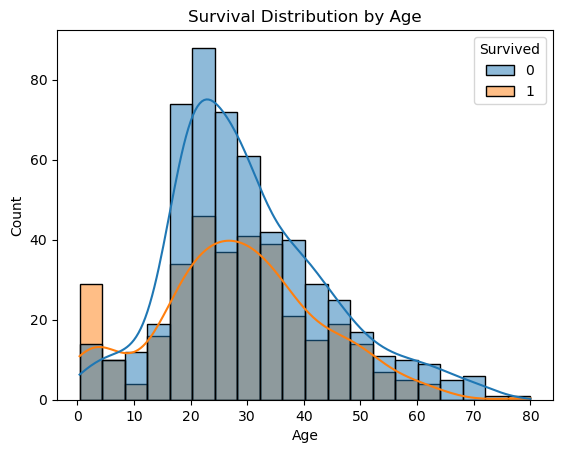

In [ ]:
# Marginal Survival Plot per Variable
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival Rate by Sex')
plt.show()

sns.histplot(data=df, x='Age', hue='Survived', kde=True, bins=20)
plt.title('Survival Distribution by Age')
plt.show()


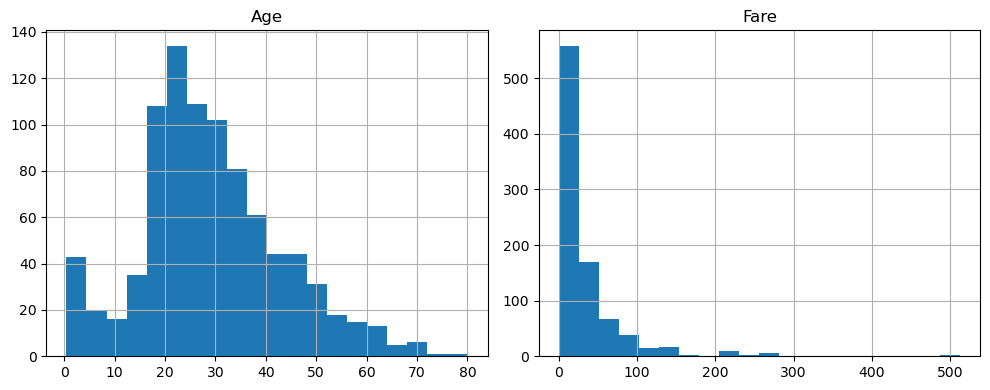

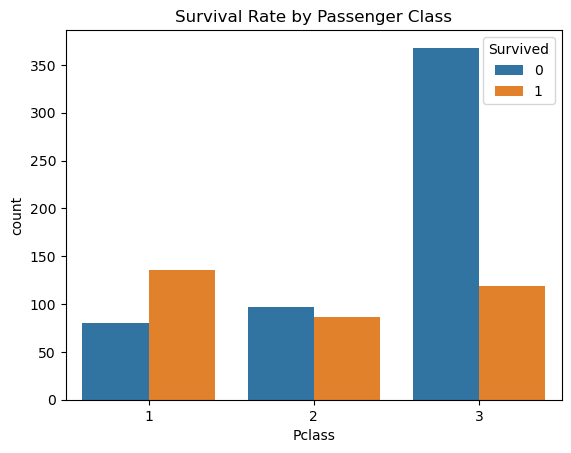

In [ ]:
#Frequencies (Histograms)
df.hist(['Age', 'Fare'], bins=20, figsize=(10, 4))
plt.tight_layout()
plt.show()


# Survival rate by gender
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival Rate by Passenger Class')
plt.show()


In [ ]:
#Bin Continuous Variables by Quantile
df['Age_Quantile'] = pd.qcut(df['Age'], q=10, duplicates='drop')

# 3. Bin Fare into 10 quantiles
df['Fare_Quantile'] = pd.qcut(df['Fare'], q=10, duplicates='drop')

# 4. Group by quantiles and calculate marginal survival rates
age_survival = df.groupby('Age_Quantile')['Survived'].mean().reset_index()
fare_survival = df.groupby('Fare_Quantile')['Survived'].mean().reset_index()

print("Age Quantile Survival Rates:\n", age_survival)
print("\nFare Quantile Survival Rates:\n", fare_survival)

Age Quantile Survival Rates:
     Age_Quantile  Survived
0  (0.419, 14.8]  0.539326
1   (14.8, 19.0]  0.372727
2   (19.0, 22.0]  0.257732
3   (22.0, 24.0]  0.416667
4   (24.0, 28.0]  0.339450
5   (28.0, 31.0]  0.382716
6   (31.0, 35.0]  0.481013
7   (35.0, 40.4]  0.380952
8   (40.4, 49.0]  0.395833
9   (49.0, 80.0]  0.329268

Fare Quantile Survival Rates:
        Fare_Quantile  Survived
0     (-0.001, 7.55]  0.141304
1      (7.55, 7.858]  0.302326
2      (7.858, 8.05]  0.182692
3       (8.05, 10.5]  0.230769
4     (10.5, 14.454]  0.428571
5   (14.454, 22.225]  0.431818
6   (22.225, 27.721]  0.494624
7   (27.721, 39.688]  0.383721
8   (39.688, 77.958]  0.528090
9  (77.958, 512.329]  0.758621


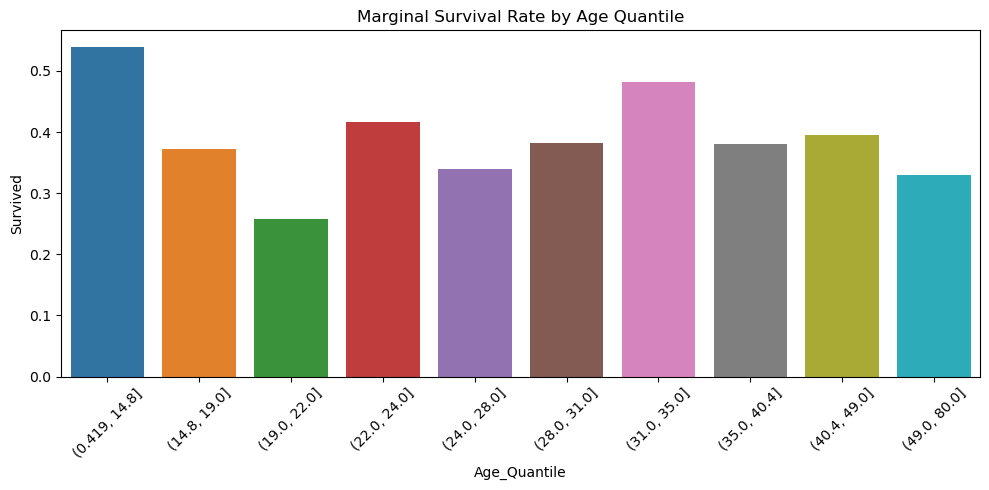

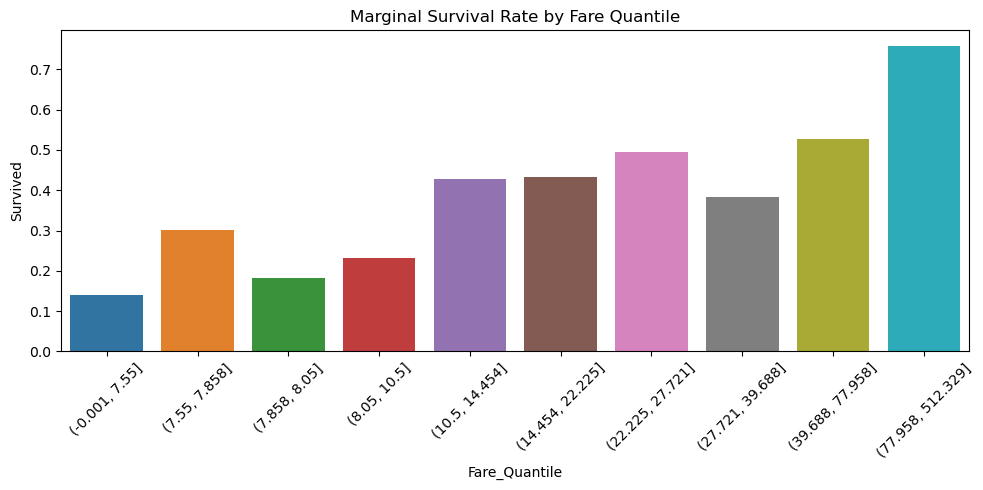

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for Age rank order in 10 quantiles
plt.figure(figsize=(10, 5))
sns.barplot(x='Age_Quantile', y='Survived', data=age_survival)
plt.xticks(rotation=45)
plt.title('Marginal Survival Rate by Age Quantile')
plt.tight_layout()
plt.show()

# Plot for Fare rank order in 10 quantiles
plt.figure(figsize=(10, 5))
sns.barplot(x='Fare_Quantile', y='Survived', data=fare_survival)
plt.xticks(rotation=45)
plt.title('Marginal Survival Rate by Fare Quantile')
plt.tight_layout()
plt.show()


In [ ]:
#Encode Categorical Variables
df['sex'] = LabelEncoder().fit_transform(df['Sex'])      # male=1, female=0


## Model Building

In [ ]:
# Drop unnecessary columns
df_model = df.drop(columns=['Name'])

# Encode 'Sex' to numeric
df_model['sex'] = LabelEncoder().fit_transform(df_model['Sex'])  # female=0, male=1
df_model = df_model.drop(columns=['Sex'])  # drop original





In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and the target column is 'Survived'

features = ['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'sex']
X = df_model[features]
y = df_model['Survived']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 1: Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Set up the hyperparameters grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization types
    'solver': ['liblinear', 'saga'],  # Solver algorithms
    'max_iter': [100, 200]  # Number of iterations
}

# Step 3: Apply GridSearchCV to find the best parameters
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

# Step 4: Get the best parameters and the best model
best_params = grid_search_lr.best_params_
best_model = grid_search_lr.best_estimator_

# Step 5: Evaluate the model on the test set
y_pred = best_model.predict(X_test_scaled)

# Step 6: Print performance metrics
print("Best Hyperparameters:", best_params)
print("\n=== Logistic Regression Evaluation ===")
print(classification_report(y_test, y_pred))

# AUC score (Area Under Curve)
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'C': 1, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}

=== Logistic Regression Evaluation ===
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       111
           1       0.72      0.57      0.63        67

    accuracy                           0.75       178
   macro avg       0.74      0.72      0.72       178
weighted avg       0.75      0.75      0.75       178

AUC Score: 0.7160145219846712


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Instantiate GridSearchCV with RandomForestClassifier
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate performance of the best model
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred_rf))
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_rf))


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       111
           1       0.83      0.66      0.73        67

    accuracy                           0.82       178
   macro avg       0.82      0.79      0.80       178
weighted avg       0.82      0.82      0.82       178

Best Model Accuracy: 0.8202247191011236


C:\Users\Shree\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


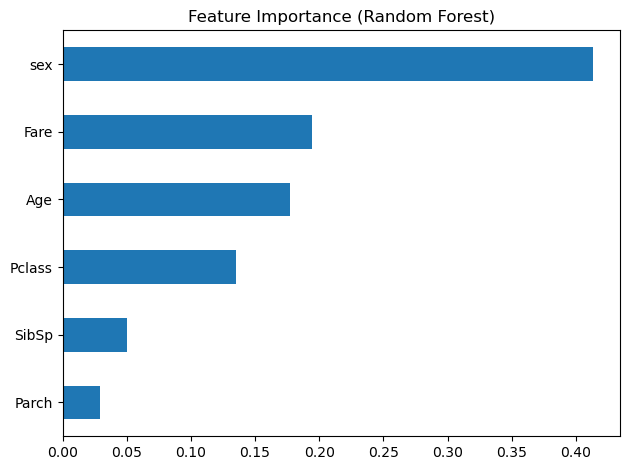

In [ ]:
importances = pd.Series(best_rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title='Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


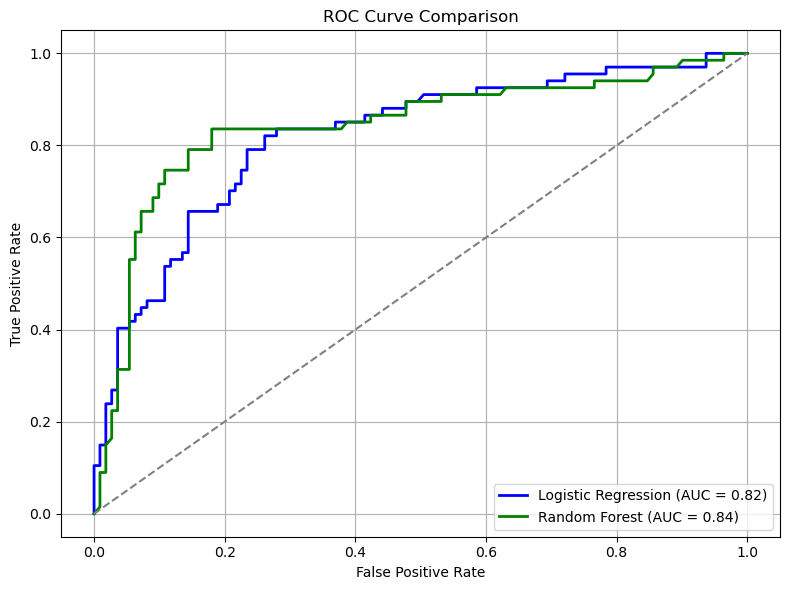

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (1)
log_probs = best_model.predict_proba(X_test_scaled)[:, 1]  # Use scaled data for logistic regression
rf_probs = best_rf_model.predict_proba(X_test)[:, 1]                # No scaling needed for Random Forest

# Compute ROC curve and AUC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = auc(fpr_log, tpr_log)

# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_log)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# Diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



### Random Forest outperforms Logistic Regression across all important metrics, especially in recall and AUC, which are crucial when identifying survivors (positives).

In [ ]:
# Get predicted probabilities for class 1 (Survived)
y_scores = best_model.predict_proba(X_test)[:, 1]

# Create a DataFrame with actual and predicted probabilities
gains_df = pd.DataFrame({
    'actual': y_test.values,
    'proba': y_scores
})

# Sort by predicted probabilities (descending)
gains_df = gains_df.sort_values(by='proba', ascending=False).reset_index(drop=True)

# Add cumulative row index
gains_df['row_num'] = np.arange(1, len(gains_df) + 1)
gains_df['cumulative_actual'] = gains_df['actual'].cumsum()

# Calculate cumulative penetration (% of total)
gains_df['penetration'] = gains_df['row_num'] / len(gains_df)
gains_df['cumulative_gain'] = gains_df['cumulative_actual'] / gains_df['actual'].sum()


C:\Users\Shree\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


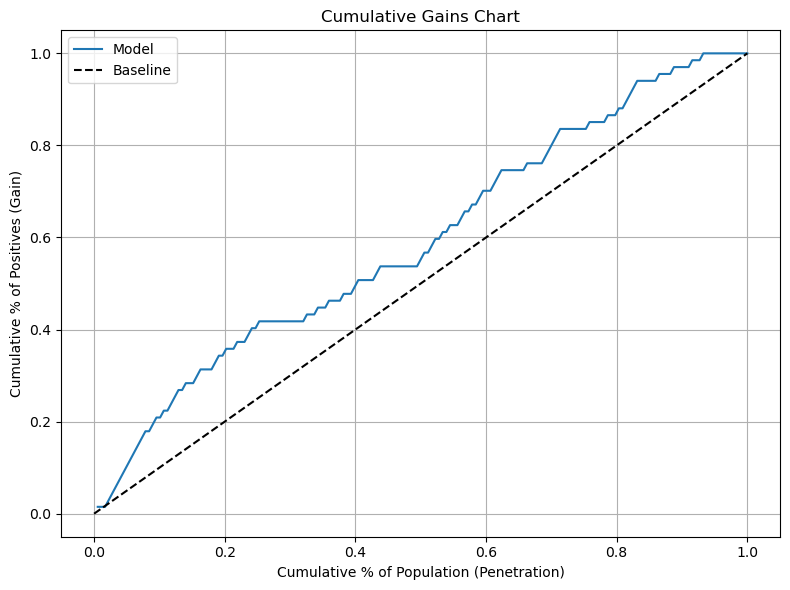

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(gains_df['penetration'], gains_df['cumulative_gain'], label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative % of Population (Penetration)')
plt.ylabel('Cumulative % of Positives (Gain)')
plt.title('Cumulative Gains Chart')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Create DataFrame for gains calculation
gains_rf = pd.DataFrame({
    'actual': y_test.values,
    'proba': rf_probs
})

# Sort by predicted probabilities
gains_rf = gains_rf.sort_values(by='proba', ascending=False).reset_index(drop=True)

# Add cumulative metrics
gains_rf['row_num'] = np.arange(1, len(gains_rf) + 1)
gains_rf['cumulative_actual'] = gains_rf['actual'].cumsum()
gains_rf['penetration'] = gains_rf['row_num'] / len(gains_rf)
gains_rf['cumulative_gain'] = gains_rf['cumulative_actual'] / gains_rf['actual'].sum()

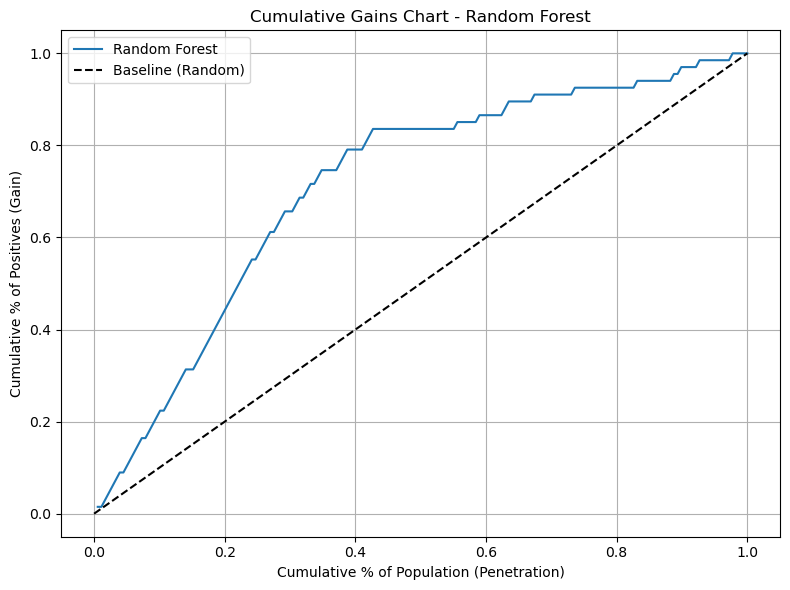

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(gains_rf['penetration'], gains_rf['cumulative_gain'], label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (Random)')
plt.xlabel('Cumulative % of Population (Penetration)')
plt.ylabel('Cumulative % of Positives (Gain)')
plt.title('Cumulative Gains Chart - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Insights from the Cumulative Gains Chart
#### What it shows:
The cumulative gains chart plots the cumulative % of true positives (survivors) captured vs. the cumulative % of the population contacted (ordered by predicted probability).

#### Interpretation of Results:

* The Random Forest curve is consistently above the diagonal (baseline), meaning it’s better than random guessing.
* Random Forest outperforms Logistic Regression in almost every metric, especially in recall and overall AUC, making it the preferred model for predicting survival on the Titanic dataset.
* Logistic Regression remains a good baseline model and offers easier interpretability, but is less effective in this case.
* For example, if you target the top 30% of passengers (based on predicted survival probability), you might capture ~55–60% of actual survivors.

* The steeper the curve, the better the model at ranking true positives higher.

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric = 'logloss')
xgb_model.fit(X_train,y_train)


preds = xgb_model.predict(X_test)
acc = accuracy_score(y_test,preds)

print(acc)

0.8202247191011236


In [ ]:
pip install optuna


     -------------------------------------- 386.6/386.6 kB 6.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0)
    }

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("🏆 Best Optuna Accuracy:", study.best_value)
print("🎯 Best Optuna Params:", study.best_params)


[I 2025-05-04 12:02:20,872] A new study created in memory with name: no-name-de155bb2-2412-464a-b06e-1e13afa22925
[I 2025-05-04 12:02:21,594] Trial 0 finished with value: 0.8180701228648486 and parameters: {'n_estimators': 286, 'max_depth': 3, 'learning_rate': 0.23376784701311246, 'subsample': 0.7523886017418605, 'colsample_bytree': 0.6661889489314309, 'gamma': 2.854082329570345, 'reg_lambda': 1.056000736289279, 'reg_alpha': 3.3194776945964204}. Best is trial 0 with value: 0.8180701228648486.
[I 2025-05-04 12:02:22,566] Trial 1 finished with value: 0.8222954749775246 and parameters: {'n_estimators': 429, 'max_depth': 5, 'learning_rate': 0.17189038894890057, 'subsample': 0.9066780731855199, 'colsample_bytree': 0.7083551073539095, 'gamma': 0.7360285554634949, 'reg_lambda': 8.280188247552235, 'reg_alpha': 6.353551956986493}. Best is trial 1 with value: 0.8222954749775246.
[I 2025-05-04 12:02:23,106] Trial 2 finished with value: 0.7997602637099192 and parameters: {'n_estimators': 143, 'max

[I 2025-05-04 12:02:40,038] Trial 21 finished with value: 0.8279292777944262 and parameters: {'n_estimators': 429, 'max_depth': 3, 'learning_rate': 0.059905207851807335, 'subsample': 0.9472870989533685, 'colsample_bytree': 0.7800708385867828, 'gamma': 1.0429839978014765, 'reg_lambda': 6.10015351392364, 'reg_alpha': 2.6169917737408896}. Best is trial 19 with value: 0.8279292777944262.
[I 2025-05-04 12:02:41,107] Trial 22 finished with value: 0.8265308161022874 and parameters: {'n_estimators': 447, 'max_depth': 3, 'learning_rate': 0.03460566606236181, 'subsample': 0.9511223384419456, 'colsample_bytree': 0.7844795384936941, 'gamma': 1.0854015760812987, 'reg_lambda': 6.138907903821432, 'reg_alpha': 3.124734800257672}. Best is trial 19 with value: 0.8279292777944262.
[I 2025-05-04 12:02:42,208] Trial 23 finished with value: 0.8236839476575767 and parameters: {'n_estimators': 396, 'max_depth': 4, 'learning_rate': 0.137458977240711, 'subsample': 0.9627968723336833, 'colsample_bytree': 0.73696

🏆 Best Optuna Accuracy: 0.83076615722705
🎯 Best Optuna Params: {'n_estimators': 401, 'max_depth': 3, 'learning_rate': 0.1065090585971546, 'subsample': 0.927089481636922, 'colsample_bytree': 0.697597779705407, 'gamma': 1.0290380107265784, 'reg_lambda': 7.671000740663466, 'reg_alpha': 3.5886540489274346}
